In this notebook we try to use the flow network for simulations

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import sys

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2022-04-25 23:22:38.804267: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-25 23:22:38.804328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sys.path.insert(0,'../')
from scripts.FlowVAEnet import FlowVAEnet
from scripts.utils import listdir_fullpath

In [3]:
tfd = tfp.distributions
tfb = tfp.bijectors

## Load trained models

In [4]:
tf.get_logger().setLevel('ERROR')
latent_dim = 10
flow_net = FlowVAEnet(latent_dim=latent_dim)
flow_net.load_flow_weights(weights_path="/pbs/throng/lsst/users/bbiswas/FlowDeblender/data/cosmos10d/flow/val_loss")
flow_net.load_vae_weights(weights_path="/pbs/throng/lsst/users/bbiswas/FlowDeblender/data/cosmos10d/vae/val_loss")
print(flow_net.vae_model.summary())

2022-04-25 23:22:49.853896: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-25 23:22:49.854001: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 23:22:49.854088: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-04-25 23:22:49.854995: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 2

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 65)                2852609   
_________________________________________________________________
latent_space (MultivariateNo ((None, 10), (None, 10))  0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         752108    
Total params: 3,604,717
Trainable params: 3,604,717
Non-trainable params: 0
_________________________________________________________________
None


### sample Latent space

sample form the base distribution, apply the bijector and then feed it to the decoder. 
Ideally, it should generate the image of a galaxy

In [5]:
zdist = tfd.Independent(
        tfd.Normal(loc=tf.zeros(10), scale=1), reinterpreted_batch_ndims=1
    )
base_sample = zdist.sample(10)

In [6]:
sampled_data = flow_net.td.sample(100000).numpy()
data =[]
for i in range(latent_dim):
    data.append(sampled_data[:, i])

Text(0, 0.5, 'distribution')

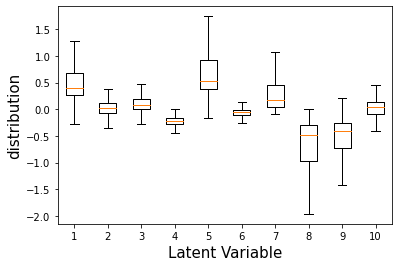

In [7]:
plt.boxplot(data, showfliers=False);
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

In [8]:
simulation = flow_net.decoder(flow_net.td.sample(10)).mean().numpy()

In [9]:
np.shape(simulation)

(10, 45, 45, 6)

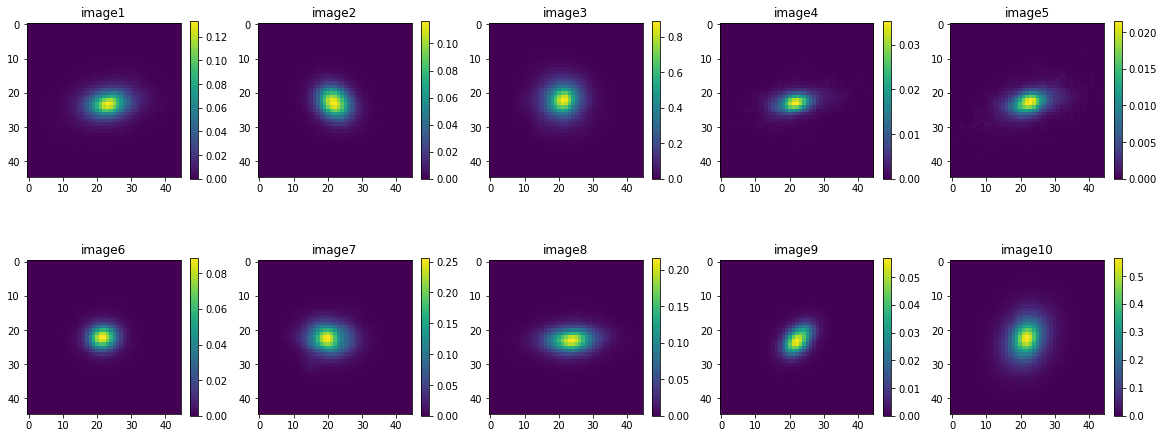

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(20,8))

for plot_row in range(2):
    for plot_col in range(5):

        im = axs[plot_row][plot_col].imshow(simulation[plot_row*5+plot_col, :, :, 2])
        fig.colorbar(im, ax=axs[plot_row][plot_col], shrink=0.8)
        axs[plot_row][plot_col].set_title("image" + str(plot_row*5+plot_col+1))